In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [28]:
from acor import acor
from astropy.cosmology import Planck15
import astropy.cosmology as cosmo
import astropy.units as u
import corner
import h5py
from matplotlib.colors import LogNorm
from multiprocessing import Pool
import pandas
import pymc3 as pm
import pystan
import scipy.integrate as si
from scipy.interpolate import interp1d, interp2d
import scipy.stats as ss
import seaborn as sns
import sys
import theano
import theano.tensor as tt
from tqdm import tnrange, tqdm_notebook

p = '/Users/wfarr/Research/CBCPopulation/O2Populations/code'
try:
    sys.path.index(p)
except ValueError:
    sys.path.append(p)
    
import vt

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Some plotting settings for the paper figures:

In [3]:
fs = 433.62/72.0
figsize_pub=(fs, fs)

Our population is going to have $5 \, M_\odot \leq m \leq 40 \, M_\odot$, and we can guarantee that there will be no systems detected with $z > 1$:

In [4]:
vt.fraction_above_threshold(40, 40, 1, 8, psd_fn=vt.ls.SimNoisePSDAdVDesignSensitivityP1200087)

0.0

Let's draw a synthetic population of sources.

In [4]:
def mc_eta_from_m1_m2(m1, m2):
    mt = m1+m2
    eta = m1*m2/(mt*mt)
    
    mc = mt*eta**(3.0/5.0)
    
    return (mc, eta)

48314.3 mergers per year out to redshift 1


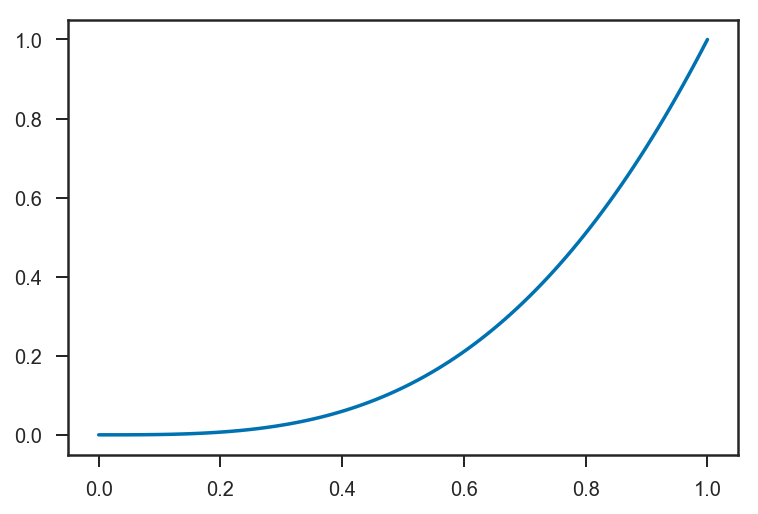

In [6]:
zs = linspace(0, 1, 100)
dNdz = 4.0*pi*100.0*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value*(1+zs)**2
N = trapz(dNdz, zs)

print('{:g} mergers per year out to redshift 1'.format(N))

dNdz /= trapz(dNdz, zs)

zcum = si.cumtrapz(dNdz, zs, initial=0)
plot(zs, zcum)

zinterp = interp1d(zcum, zs)

We will generate one year of mergers at design sensitivity (out to redshift 1, which is the detection horizon for our most massive black holes).  The mass distribution will be
$$
p\left( m_1, m_2 \right) \propto \frac{m_1^{-1}}{m_1 - M_\mathrm{min}}
$$
(flat in log $m_1$ and flat in $q$) and the rate will be 
$$
\frac{\mathrm{d} N}{\mathrm{d} V_C \mathrm{d} t} = 100 \, \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1} \left( 1 + z \right)^3
$$
in the comoving frame, or an observed merger density of 
$$
\frac{\mathrm{d} N}{\mathrm{d} z} = 100 \, \mathrm{Gpc}^{-3} \frac{\mathrm{d} V_C}{\mathrm{d} z} \left( 1 + z \right)^2.
$$

Let's talk a bit about the observational model.  We imagine that the true amplitude of the source in our detector (we will use only one detector here---with a hack that gives uncertainty appropriate to multiple detectors) is given by 
$$
A_\mathrm{true} = A_\mathrm{opt}\left( m_1, m_2, d_L \right) \Theta_\mathrm{true},
$$
where $A_\mathrm{opt}$ is the amplitude for a face-on, overhead source with the given parameters, and $\Theta_\mathrm{true}$ is drawn from the isotropic distribution of angular amplitude factors given, e.g., in [Finn & Chernoff (1993)](https://ui.adsabs.harvard.edu/#abs/1993PhRvD..47.2198F/abstract).  We imagine that we measure the amplitude with unit uncertainty:
$$
A_\mathrm{obs} = A_\mathrm{true} + N(0,1),
$$
and we also measure the angular factor
$$
\Theta_\mathrm{obs} = \Theta_\mathrm{true} + N\left(0, \sigma_\Theta\right)
$$
with 
$$
\sigma_\Theta = 0.03 \times \frac{8}{A_\mathrm{true}}.
$$
This value of $\sigma_\Theta$ is chosen to match the uncertainty of a median angular source at threshold to the relative distance uncertainty of GW170814.  Note that the observation of the angular factor is not restricted to the range $[0,1]$.  Only events with $A_\mathrm{obs} > 8$ are considered "detected."

We also observe a chirp mass: 
$$
\log \mathcal{M}_\mathrm{obs} = \log \left( \left( 1+z \right) \mathcal{M}_\mathrm{true}\left( m_1, m_2 \right) \right) + N\left( 0, \sigma_\mathrm{M}\right)
$$
and symmetric mass ratio
$$
\eta_\mathrm{obs} = \eta_\mathrm{true} \left( m_1, m_2 \right) + N\left( 0, \sigma_\eta \right)
$$
with 
$$
\sigma_\mathrm{M} = \sigma_\eta = 0.03 \times \frac{8}{A_\mathrm{true}};
$$
this uncertainty is tuned to match LVT151012.

In [7]:
rstate = random.get_state()
random.seed(752812)

try:
    ngen1 = random.poisson(N)
    ngen4 = random.poisson(4*N) # ngen1 + ngen4 is five years' worth of observations
    N_1yr = -1

    MMin = 5
    MMax = 40

    m1s = []
    m2s = []
    zs = []
    dls = []
    thetas = []

    mc_obs = []
    eta_obs = []
    A_obs = []
    theta_obs = []
    
    sigma_mc = []
    sigma_eta = []
    sigma_theta = []
    
    ts = concatenate(([0.0], sort(vt.thetas), [1.0]))
    
    tcum = interp1d(linspace(0, 1, ts.shape[0]), ts)

    for i in tnrange(ngen1+ngen4):
        if i == ngen1:
            # One year of events has elapsed
            N_1yr = len(m1s)
        m1 = exp(log(MMin) + log(MMax/MMin)*rand())
        m2 = random.uniform(low=MMin, high=m1)
        z = zinterp(rand())
        dl = Planck15.luminosity_distance(z).to(u.Gpc).value

        opt_snr = vt.optimal_snr(m1, m2, z, psd_fn=vt.ls.SimNoisePSDAdVDesignSensitivityP1200087)
        
        th = tcum(rand())
        
        A = th * opt_snr
        
        sa = 1.0
        st = 0.15*8.0/A
        
        Aobs = random.normal(loc=A, scale=sa)

        if Aobs > 8:        
            m1s.append(m1)
            m2s.append(m2)
            zs.append(z)
            dls.append(dl)
            thetas.append(th)
            
            th_obs = th + st*randn()

            mc, eta = mc_eta_from_m1_m2(m1, m2)

            sm = 8/Aobs*0.017
            se = 8/Aobs*0.017

            mco = random.lognormal(mean=log(mc*(1+z)), sigma=sm)
            etao = eta + se*randn() # This can give eta > 0.25 or eta < 0, but truncating causes numerical prob's in Stan, apparently

            mc_obs.append(mco)
            eta_obs.append(etao)
            A_obs.append(Aobs)
            theta_obs.append(th_obs)
            
            sigma_mc.append(sm)
            sigma_eta.append(se)
            sigma_theta.append(st)
finally:
    random.set_state(rstate)
    
with h5py.File('observations.h5', 'w') as out:
    out.attrs['N_1yr'] = N_1yr
    
    tg = out.create_group('truth')
    for n, d in (('m1', m1s), ('m2', m2s), ('z', zs), ('dl', dls), ('theta', thetas)):
        tg.create_dataset(n, data=array(d), compression='gzip', shuffle=True)
    
    og = out.create_group('observations')
    for n, d in (('mc', mc_obs), ('eta', eta_obs), ('A', A_obs), ('theta', theta_obs), ('sigma_mc', sigma_mc), ('sigma_eta', sigma_eta), ('sigma_theta', sigma_theta)):
        og.create_dataset(n, data=array(d), compression='gzip', shuffle=True)

100%|██████████| 241187/241187 [39:01<00:00, 103.00it/s]


Executing the code below will re-load the generated observations:

In [4]:
MMin = 5
MMax = 40

with h5py.File('observations.h5', 'r') as inp:
    N_1yr = inp.attrs['N_1yr']
    
    m1s = array(inp['truth']['m1'])
    m2s = array(inp['truth']['m2'])
    zs = array(inp['truth']['z'])
    dls = array(inp['truth']['dl'])
    thetas = array(inp['truth']['theta'])
    
    mc_obs = array(inp['observations']['mc'])
    eta_obs = array(inp['observations']['eta'])
    A_obs = array(inp['observations']['A'])
    theta_obs = array(inp['observations']['theta'])
    sigma_mc = array(inp['observations']['sigma_mc'])
    sigma_eta = array(inp['observations']['sigma_eta'])
    sigma_theta = array(inp['observations']['sigma_theta'])

Can we see the right behaviour in the maximum (or minimum?) mass?  Below is plotted the observed $\mathcal{M}$ versus $\mathcal{M}^{5/6}/A \simeq d_L$ (with errobars) for the hypothetical catalog.  

If we know the exact observed masses and distances to all the events, what can we reconstruct about the Hubble constant?

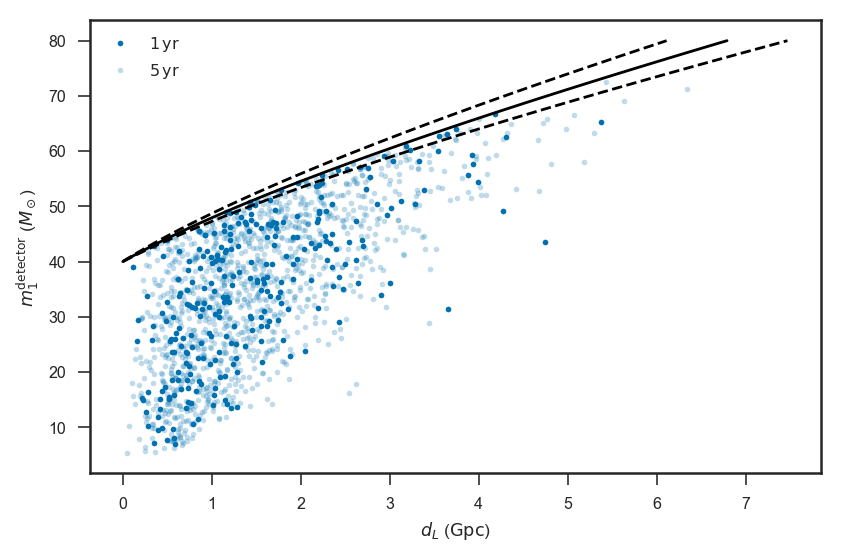

In [6]:
with sns.plotting_context('paper', rc={'figure.figsize': figsize_pub}):

    plot(dls[:N_1yr], (1+zs[:N_1yr])*m1s[:N_1yr], '.', label=r'$1\,\mathrm{yr}$')
    plot(dls, (1+zs)*m1s, '.', alpha=0.25, color=sns.color_palette()[0], label=r'$5\,\mathrm{yr}$')
    xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
    ylabel(r'$m_1^\mathrm{detector}$ ($M_\odot$)')

    z = linspace(0,1,100)
    d = Planck15.luminosity_distance(z).to(u.Gpc).value

    plot(d, (1+z)*MMax, '-k')
    plot(0.9*d, (1+z)*MMax, '--k')
    plot(1.1*d, (1+z)*MMax, '--k')

    legend(loc='best')

    tight_layout()
    savefig('paper/plots/m1-dL-true.pdf')
    
    with h5py.File('paper/plots/m1-dL-true.h5', 'w') as out:
        def cd(g,n,d):
            g.create_dataset(n, data=d, compression='gzip', shuffle=True)
        g1 = out.create_group('1yr')
        cd(g1, 'dls', dls[:N_1yr])
        cd(g1, 'zs', zs[:N_1yr])
        cd(g1, 'm1s', m1s[:N_1yr])
        
        g5 = out.create_group('5yr')
        cd(g5, 'dls', dls)
        cd(g5, 'zs', zs)
        cd(g5, 'm1s', m1s)
        
        c = out.create_group('cosmology')
        cd(c, 'dls', d)
        cd(c, 'MMax', (1+z)*MMax)
        cd(c, 'dls_0.9', 0.9*d)
        cd(c, 'dls_1.1', 1.1*d)

We will ignore issues of estimating the population for the moment, and just assume that it is uniform in $m_1$ and uniform in $z$, and fit for $M_\mathrm{max}$ and the cosmological parameters.

In [14]:
mperfect = pystan.StanModel(file='PISNPerfectMass.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5b2b71ae05596cac82fe8d3efb726ddc NOW.


In file included from /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpXJqtlb/stanfit4anon_model_5b2b71ae05596cac82fe8d3efb726ddc_7759301329656571241.cpp:640:
In file included from /Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
In file included from /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpXJqtlb/stanfit4anon_model_5b2b71ae05596cac82fe8d3efb726ddc_7759301329656571241.

ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: ignoring file /Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX10.13.sdk/usr/lib/libSystem.tbd, file was built for unsupported file format ( 0x2D 0x2D 0x2D 0x20 0x21 0x74 0x61 0x70 0x69 0x2D 0x74 0x62 0x64 0x2D 0x76 0x33 ) which is not the architecture being linked (x86_64): /Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX10.13.sdk/usr/lib/libSystem.tbd


In [15]:
dperfect_full = {
    'nobs': len(m1s),
    'm1_obs': m1s*(1+zs),
    'dls': dls
}

dperfect_1yr = {
    'nobs': N_1yr,
    'm1_obs': m1s[:N_1yr]*(1+zs[:N_1yr]),
    'dls': dls[:N_1yr]
}

In [16]:
fperfect_full = mperfect.sampling(data=dperfect_full)
fperfect_1yr = mperfect.sampling(data=dperfect_1yr)

In [17]:
print(fperfect_full)
print(fperfect_1yr)

Inference for Stan model: anon_model_5b2b71ae05596cac82fe8d3efb726ddc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
H0         67.66    0.02   0.75  66.22  67.22  67.68  68.05  69.24 1808.0    1.0
dMMax       0.03  5.7e-4   0.03 4.8e-4 7.3e-3   0.02   0.04    0.1 2287.0    1.0
dH          4.43  1.1e-3   0.05   4.33   4.41   4.43   4.46   4.53 1827.0    1.0
zs[0]       0.09  2.2e-5 9.2e-4   0.09   0.09   0.09   0.09   0.09 1809.0    nan
zs[1]       0.32  7.2e-5 3.1e-3   0.32   0.32   0.32   0.33   0.33 1810.0    1.0
zs[2]       0.28  6.4e-5 2.7e-3   0.28   0.28   0.28   0.29   0.29 1810.0    1.0
zs[3]       0.12  2.8e-5 1.2e-3   0.11   0.11   0.12   0.12   0.12 1809.0    1.0
zs[4]       0.17  4.0e-5 1.7e-3   0.17   0.17   0.17   0.17   0.17 1810.0    1.0
zs[5]       0.15  3.5e-5 1.5e-3   0.15   0.15   0.15   0.15   0.15 1810.0    1.0
z

Inference for Stan model: anon_model_5b2b71ae05596cac82fe8d3efb726ddc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
H0        68.59    0.07   2.87  63.48  66.77  68.38  70.15   75.3 1903.0    1.0
dMMax      0.14  2.9e-3   0.14 3.3e-3   0.04    0.1   0.19   0.53 2532.0    1.0
dH         4.38  4.0e-3   0.18   3.98   4.27   4.38   4.49   4.72 2026.0    1.0
zs[0]      0.09  8.1e-5 3.5e-3   0.08   0.09   0.09   0.09    0.1 1906.0    1.0
zs[1]      0.33  2.7e-4   0.01   0.31   0.32   0.33   0.33   0.35 1910.0    1.0
zs[2]      0.29  2.4e-4   0.01   0.27   0.28   0.29   0.29   0.31 1909.0    1.0
zs[3]      0.12  1.0e-4 4.6e-3   0.11   0.11   0.12   0.12   0.13 1907.0    1.0
zs[4]      0.17  1.5e-4 6.6e-3   0.16   0.17   0.17   0.18   0.19 1908.0    1.0
zs[5]      0.15  1.3e-4 5.8e-3   0.14   0.15   0.15   0.15   0.16 1908.0    1.0
zs[6]      

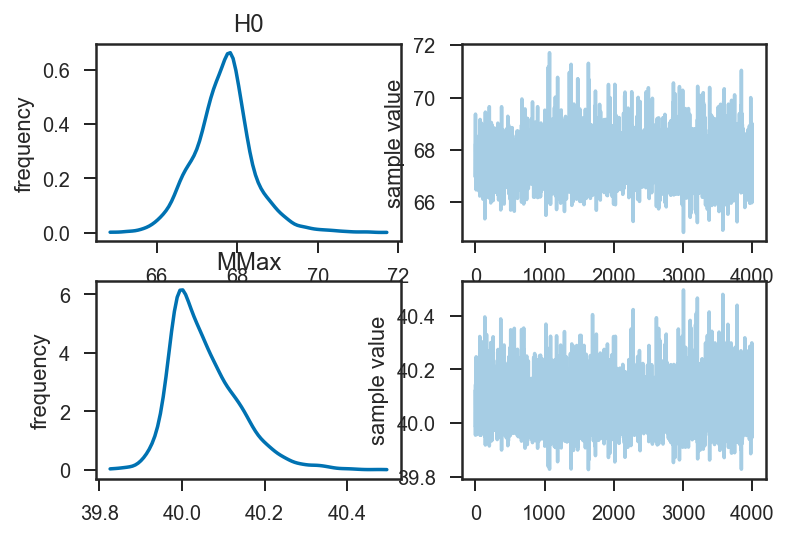

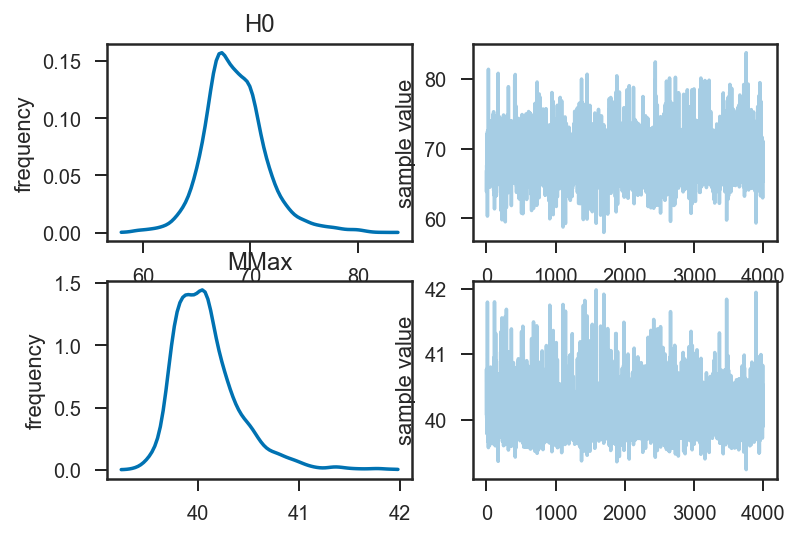

In [18]:
fperfect_full.plot(['H0', 'MMax'])
fperfect_1yr.plot(['H0', 'MMax']);

In [19]:
cperfect_full = fperfect_full.extract()
cperfect_1yr = fperfect_1yr.extract()

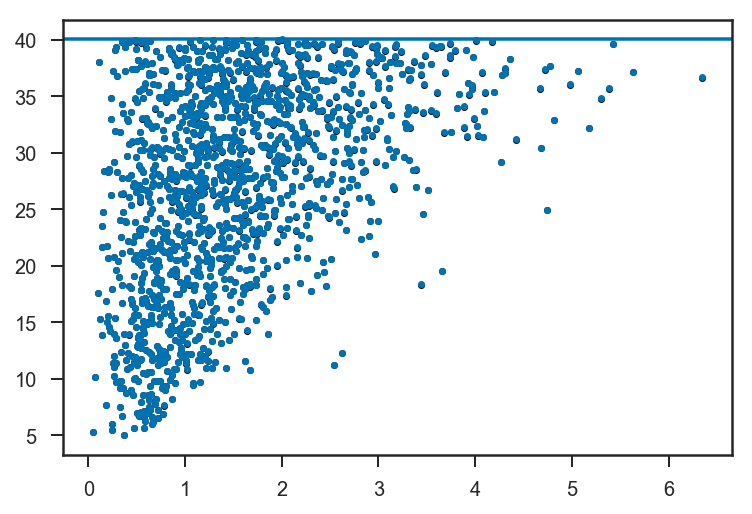

In [20]:
plot(dls, m1s, '.k')
plot(dls, m1s*(1+zs)/(1+cperfect_full['zs'][10,:]), '.')
axhline(cperfect_full['MMax'][10])

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


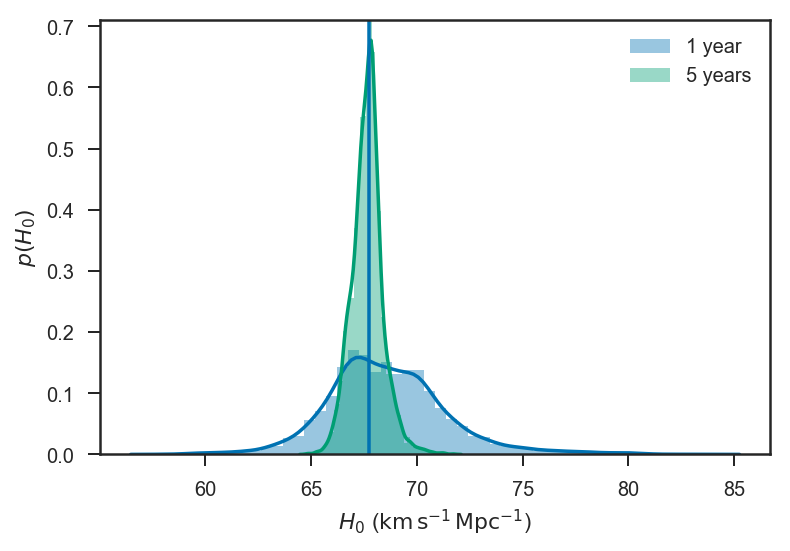

In [21]:
sns.distplot(cperfect_1yr['H0'], label='1 year')
sns.distplot(cperfect_full['H0'], label='5 years')
axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value)
xlabel(r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
ylabel(r'$p\left( H_0 \right)$')
legend(loc='best')

In [22]:
print('H0 = {:.1f} +/- {:.1f} km/s/Mpc (1 years)'.format(mean(cperfect_1yr['H0']), std(cperfect_1yr['H0'])))
print('H0 = {:.1f} +/- {:.1f} km/s/Mpc (5 years)'.format(mean(cperfect_full['H0']), std(cperfect_full['H0'])))

H0 = 68.6 +/- 2.9 km/s/Mpc (1 years)
H0 = 67.7 +/- 0.7 km/s/Mpc (5 years)


Now we begin to account for observational uncertainty.  We will try to follow the above design as closely as possible (as opposed to actually modelling the population, which is also possible, and would probably return a bit better results).  So, we will first produce posteriors (with flat priors, so proportional to the likelihoods) on $m_1^\mathrm{obs}$, $m_2^\mathrm{obs}$, and $d_L$, and then fit the $m_1$ versus $d_L$ curve to extract the cosmography.

In [12]:
model = pystan.StanModel(file='PISNLineParameters.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4390042b134149f3db9994addecbd931 NOW.


In file included from /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpCKUVR7/stanfit4anon_model_4390042b134149f3db9994addecbd931_5238975424880861927.cpp:640:
In file included from /Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
In file included from /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpCKUVR7/stanfit4anon_model_4390042b134149f3db9994addecbd931_5238975424880861927.

For this model, we will need to have the optimal SNR at $d_L = 1 \, \mathrm{Gpc}$ in a grid; the cell below takes a long time to run, but saves its results to disk.  Executing the next cell will re-load the stored data.

In [10]:
ms = logspace(log10(1), log10(200), 100)
def osnr(m1m2):
    m1, m2 = m1m2
    z = cosmo.z_at_value(Planck15.luminosity_distance, 1*u.Gpc)
    
    # m1, m2 are the *observed* masses, so we need to un-redshift them:
    return vt.optimal_snr(m1/(1+z), m2/(1+z), z, psd_fn=vt.ls.SimNoisePSDAdVDesignSensitivityP1200087)

M1S, M2S = meshgrid(ms, ms, indexing='ij')

p = Pool()
try:
    OSNRS = reshape(array(p.map(osnr, zip(M1S.ravel(), M2S.ravel()))), M1S.shape)
finally:
    p.close()
    
with h5py.File('optimal_snr.h5', 'w') as out:
    out.create_dataset('ms', data=ms, compression='gzip', shuffle=True)
    out.create_dataset('SNR', data=OSNRS, compression='gzip', shuffle=True)

Run this cell to re-load the optimal SNR grid.

In [13]:
with h5py.File('optimal_snr.h5', 'r') as inp:
    ms = array(inp['ms'])
    OSNRS = array(inp['SNR'])
M1S, M2S = meshgrid(ms, ms, indexing='ij')

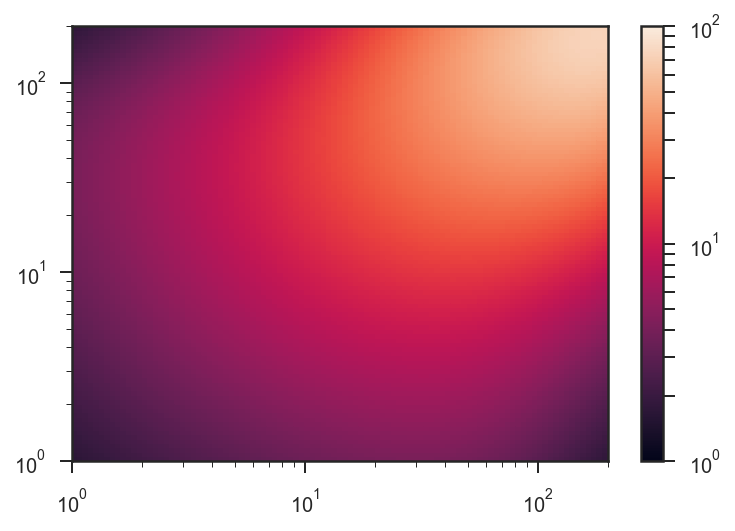

In [14]:
pcolormesh(M1S, M2S, OSNRS, norm=LogNorm(), vmin=1, vmax=100)
colorbar()
xscale('log')
yscale('log')

In [15]:
dl_max = Planck15.luminosity_distance(2.0).to(u.Gpc).value

In [16]:
chain = {'m1s': zeros((0, 4000)),
         'm2s': zeros((0, 4000)),
         'mcs': zeros((0, 4000)),
         'etas': zeros((0, 4000)),
         'qs': zeros((0, 4000)),
         'dLs': zeros((0, 4000)),
         'opt_snrs': zeros((0, 4000)),
         'thetas': zeros((0,4000))}

for i in tnrange(len(m1s)):
    d = {
        'mc_obs': mc_obs[i],
        'eta_obs': eta_obs[i],
        'A_obs': A_obs[i],
        'theta_obs': theta_obs[i],
        
        'sigma_mc': sigma_mc[i],
        'sigma_eta': sigma_eta[i],
        'sigma_theta': sigma_theta[i],
        
        'nm': len(ms),
        'ms': ms,
        'opt_snrs': OSNRS,
        
        'dL_max': dl_max
    }
    init = {
        'm1': m1s[i],
        'm2': m2s[i],
        'dL': dls[i],
        'theta': thetas[i]
    }
    f = model.sampling(data=d, iter=4000, thin=2, init=(init,)*4)
    c = f.extract(permuted=True)
    
    for n in ['m1', 'm2', 'mc', 'eta', 'dL', 'opt_snr', 'theta']:
        ns = n + 's'
        chain[ns] = row_stack((chain[ns], c[n]))
        
with h5py.File('parameters.h5', 'w') as out:
    out.attrs['N_1yr'] = N_1yr
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        out.create_dataset(n, data=chain[n], compression='gzip', shuffle=True)

In [17]:
chain = {}
with h5py.File('parameters.h5', 'r') as inp:
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        chain[n] = array(inp[n])
chain_1yr = {}
for k in chain.keys():
    chain_1yr[k] = chain[k][:N_1yr, :]

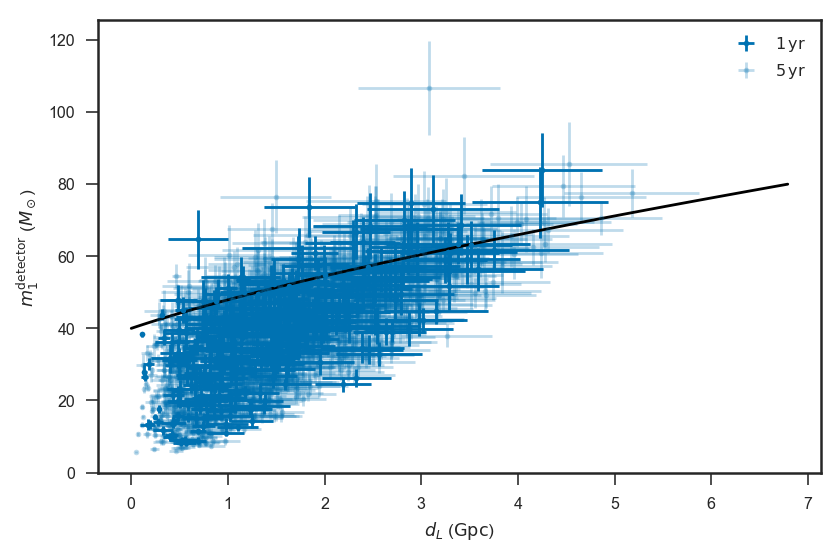

In [18]:
with sns.plotting_context('paper', rc={'figure.figsize': figsize_pub}):
    m1o = chain_1yr['m1s']
    dlo = chain_1yr['dLs']

    m1a = chain['m1s']
    dla = chain['dLs']

    errorbar(np.mean(dlo, axis=1), np.mean(m1o, axis=1), xerr=std(dlo, axis=1), yerr=std(m1o, axis=1), fmt='.', label=r'$1 \, \mathrm{yr}$')
    errorbar(np.mean(dla, axis=1), np.mean(m1a, axis=1), xerr=std(dla, axis=1), yerr=std(m1a, axis=1), fmt='.', color=sns.color_palette()[0], alpha=0.25, label=r'$5 \, \mathrm{yr}$')

    z = linspace(0, 1, 100)
    dl = Planck15.luminosity_distance(z).to(u.Gpc).value

    plot(dl, 40*(1+z), '-k')

    legend(loc='best')
    
    xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
    ylabel(r'$m_1^\mathrm{detector}$ ($M_\odot$)')
    
    tight_layout()
    savefig('paper/plots/m1-dL-obs.pdf')
    
    with h5py.File('paper/plots/m1-dL-obs.h5', 'w') as out:
        def cd(g, n, d):
            g.create_dataset(n, data=d, compression='gzip', shuffle=True)
        g1 = out.create_group('1yr')
        cd(g1, 'dl_mean', mean(dlo, axis=1))
        cd(g1, 'dl_std', std(dlo, axis=1))
        cd(g1, 'm1_mean', mean(m1o, axis=1))
        cd(g1, 'm1_std', std(m1o, axis=1))
        
        g5 = out.create_group('5yr')
        cd(g5, 'dl_mean', mean(dla, axis=1))
        cd(g5, 'dl_std', std(dla, axis=1))
        cd(g5, 'm1_mean', mean(m1a, axis=1))
        cd(g5, 'm1_std', std(m1a, axis=1))
        
        c = out.create_group('cosmology')
        cd(c, 'dls', dl)
        cd(c, 'MMax', 40*(1+z))

Let's just check the uncertainty that is produced in our simulations.  For GW170814, we have 

* $m_1 = 30.5^{+5.7}_{-3.0} \, M_\odot$
* $d_L = 540^{+130}_{-210} \, \mathrm{Mpc}$

both at 90% CL.  That corresponds to a range in $\log m_1$ of $\Delta_{90} \log m_1 = 0.27$ and a range of $d_L$ of $\Delta_{90} d_L = 0.71$.  How does this compare to a typical and marginal detected event from our sample?

In [19]:
delta90_logm1 = log(percentile(chain['m1s'], 95, axis=1))-log(percentile(chain['m1s'], 5, axis=1))
delta90_logdl = log(percentile(chain['dLs'], 95, axis=1))-log(percentile(chain['dLs'], 5, axis=1))

In [20]:
print('median d90(log(m1)) = {:.2f}'.format(median(delta90_logm1)))
print('95th percentile d90(log(m1)) = {:.2f}'.format(percentile(delta90_logm1, 95)))

median d90(log(m1)) = 0.31
95th percentile d90(log(m1)) = 0.43


In [21]:
print('median d90(log(dl)) = {:.2f}'.format(median(delta90_logdl)))
print('95th percentile d90(log(dl)) = {:.2f}'.format(percentile(delta90_logdl, 95)))

median d90(log(dl)) = 0.57
95th percentile d90(log(dl)) = 1.25


It is fun to look at some of the inferences; execute the cell below to view a random event in $m_1$-$m_2$-$d_L$ space.  You can also change the number of samples used to construct the density.

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color',

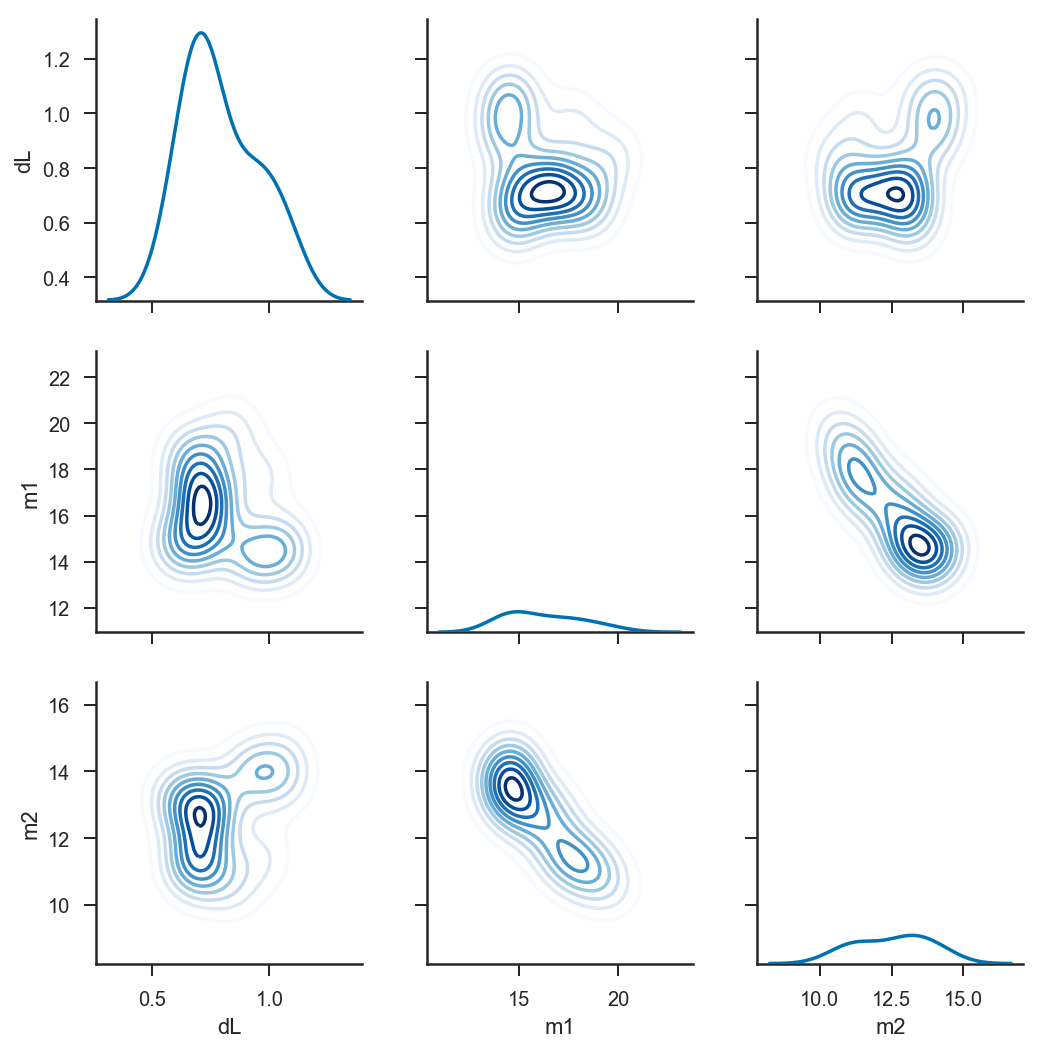

In [40]:
i = randint(chain['m1s'].shape[0])
n = 16
s = random.choice(chain['m1s'].shape[1], replace=False, size=n)

df = pandas.DataFrame({'m1': chain['m1s'][i,s],
                       'm2': chain['m2s'][i,s],
                       'dL': chain['dLs'][i,s]})

g = sns.PairGrid(df)
g.map_offdiag(sns.kdeplot, cmap='Blues')
g.map_diag(sns.kdeplot)

From the plot above, it is clear that we will need to model the population in order to get the most from this data set; simply doing a linear regression is likely to be biased because the population prior is *not* flat in $m_1$, $q$, and $d_L$.  If we are going to model the population, selection effects will become important, so let's produce a sample of selected systems drawn flat in $m_1^\mathrm{obs}$, $q$, and $d_L$ so we can Monte-Carlo the selection integral.

In [25]:
np.min(chain['m2s']), np.max(chain['m1s']), np.max(chain['dLs'])

(3.303958375045532, 154.8660841285098, 9.993144061208575)

In [34]:
# Will iterate until there are this many events within the range [MMin, MMax]
N_selection = 1024

print('Generating {:d} samples w/i true mass range'.format(N_selection))

zm = cosmo.z_at_value(Planck15.luminosity_distance, np.max(chain['dLs'])*u.Gpc)
dLmax = 1.2*np.max(chain['dLs'])

MObsMin = 0.5*np.min(chain['m2s'])
MObsMax = 1.2*np.max(chain['m1s'])

m1s_det = []
m2s_det = []
dls_det = []
N_gen = 0
N_within = 0 # Number actually within our mass ranges.

ts = concatenate(([0.0], sort(vt.thetas), [1.0]))

tcum = interp1d(linspace(0, 1, ts.shape[0]), ts)

with tqdm_notebook(total=N_selection) as bar:
    while N_within < N_selection:
        N_gen += 1
        # Draw uniformly in the rectange
        maobs = random.uniform(low=MObsMin, high=MObsMax)
        mbobs = random.uniform(low=MObsMin, high=MObsMax)
        
        # Enforce m1 > m2
        m1obs = max(maobs, mbobs)
        m2obs = min(maobs, mbobs)
        
        dl = random.uniform(low=1e-6, high=dLmax) # Between 1 kpc and dLmax
        z = cosmo.z_at_value(Planck15.luminosity_distance, dl*u.Gpc)

        opt_snr = vt.optimal_snr(m1obs/(1+z), m2obs/(1+z), z, psd_fn=vt.ls.SimNoisePSDAdVDesignSensitivityP1200087)

        th = tcum(rand())

        A = th * opt_snr

        sa = 1.0
        st = 0.15*8.0/A

        Aobs = random.normal(loc=A, scale=sa)

        if Aobs > 8:     
            if m1obs / (1+z) > MMin and m1obs / (1+z) < MMax:
                N_within += 1
                bar.update(1)
            
            m1s_det.append(m1obs)
            m2s_det.append(m2obs)
            dls_det.append(dl)

with h5py.File('selected.h5', 'w') as out:
    out.attrs['MObsMin'] = MObsMin
    out.attrs['MObsMax'] = MObsMax
    out.attrs['dLMax'] = dLmax
    out.attrs['NGen'] = N_gen
    
    for n, d in (('m1', m1s_det), ('m2', m2s_det), ('dl', dls_det)):
        out.create_dataset(n, data=array(d), compression='gzip', shuffle=True)

Generating 1024 samples w/i true mass range


Executing the cell below will re-load the detected set of systems 

In [5]:
with h5py.File('selected.h5', 'r') as inp:
    MObsMin = inp.attrs['MObsMin']
    MObsMax = inp.attrs['MObsMax']
    dLmax = inp.attrs['dLMax']
    N_gen = inp.attrs['NGen']
    
    m1s_det = array(inp['m1'])
    m2s_det = array(inp['m2'])
    dls_det = array(inp['dl'])

Here is the spacing between detected samples as a function of mass; we use $m_1$ to determine the spacing at high mass and $m_2$ to determine the spacing at low mass.

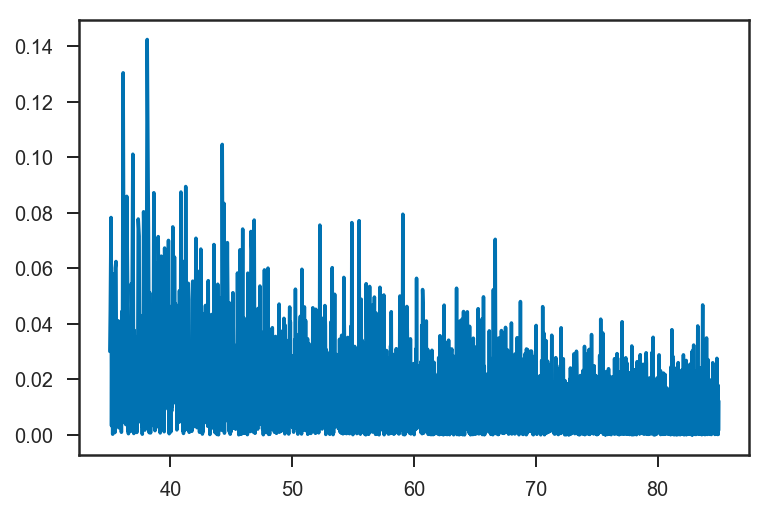

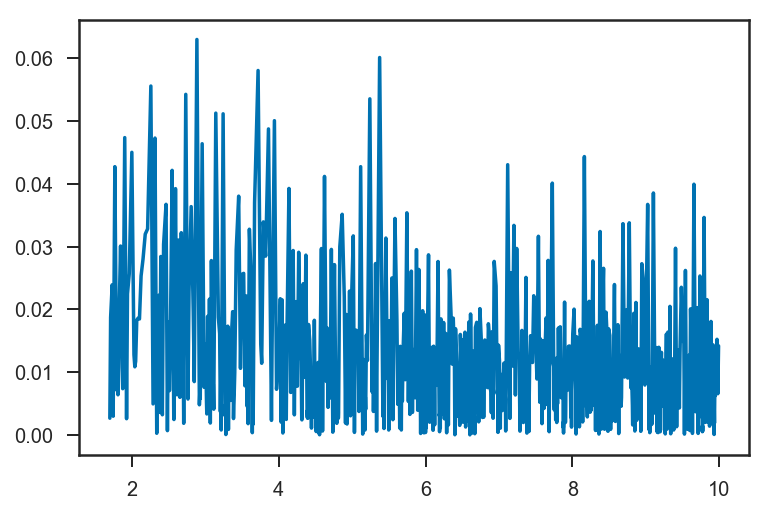

In [38]:
m = sort(m1s_det)
x = 0.5*(m[:-1]+m[1:])
y = diff(m)

figure()
s = (35 < x) & (x < 85)
plot(x[s],y[s])

m = sort(m2s_det)
x = 0.5*(m[:-1] + m[1:])
y = diff(m)

figure()
s = (1 < x) & (x < 10)
plot(x[s],y[s])

And our population re-analysis model; the fitting is done in the ``fit.py`` script for both one year (below) and five years' data (further on).

In [12]:
chain_pop_1yr = {}
nbest = 16
n2best = 400
for nn in [nbest]:#n2best, nbest]:
    c = {}
    with h5py.File('population_1yr_{:04d}.h5'.format(nn), 'r') as inp:
        for n in ['H0', 'R0', 'MMax', 'MMin', 'alpha', 'gamma']:
            c[n] = array(inp[n])
    chain_pop_1yr[nn] = c

Let's check the corner plot for the largest number of samples in a run:

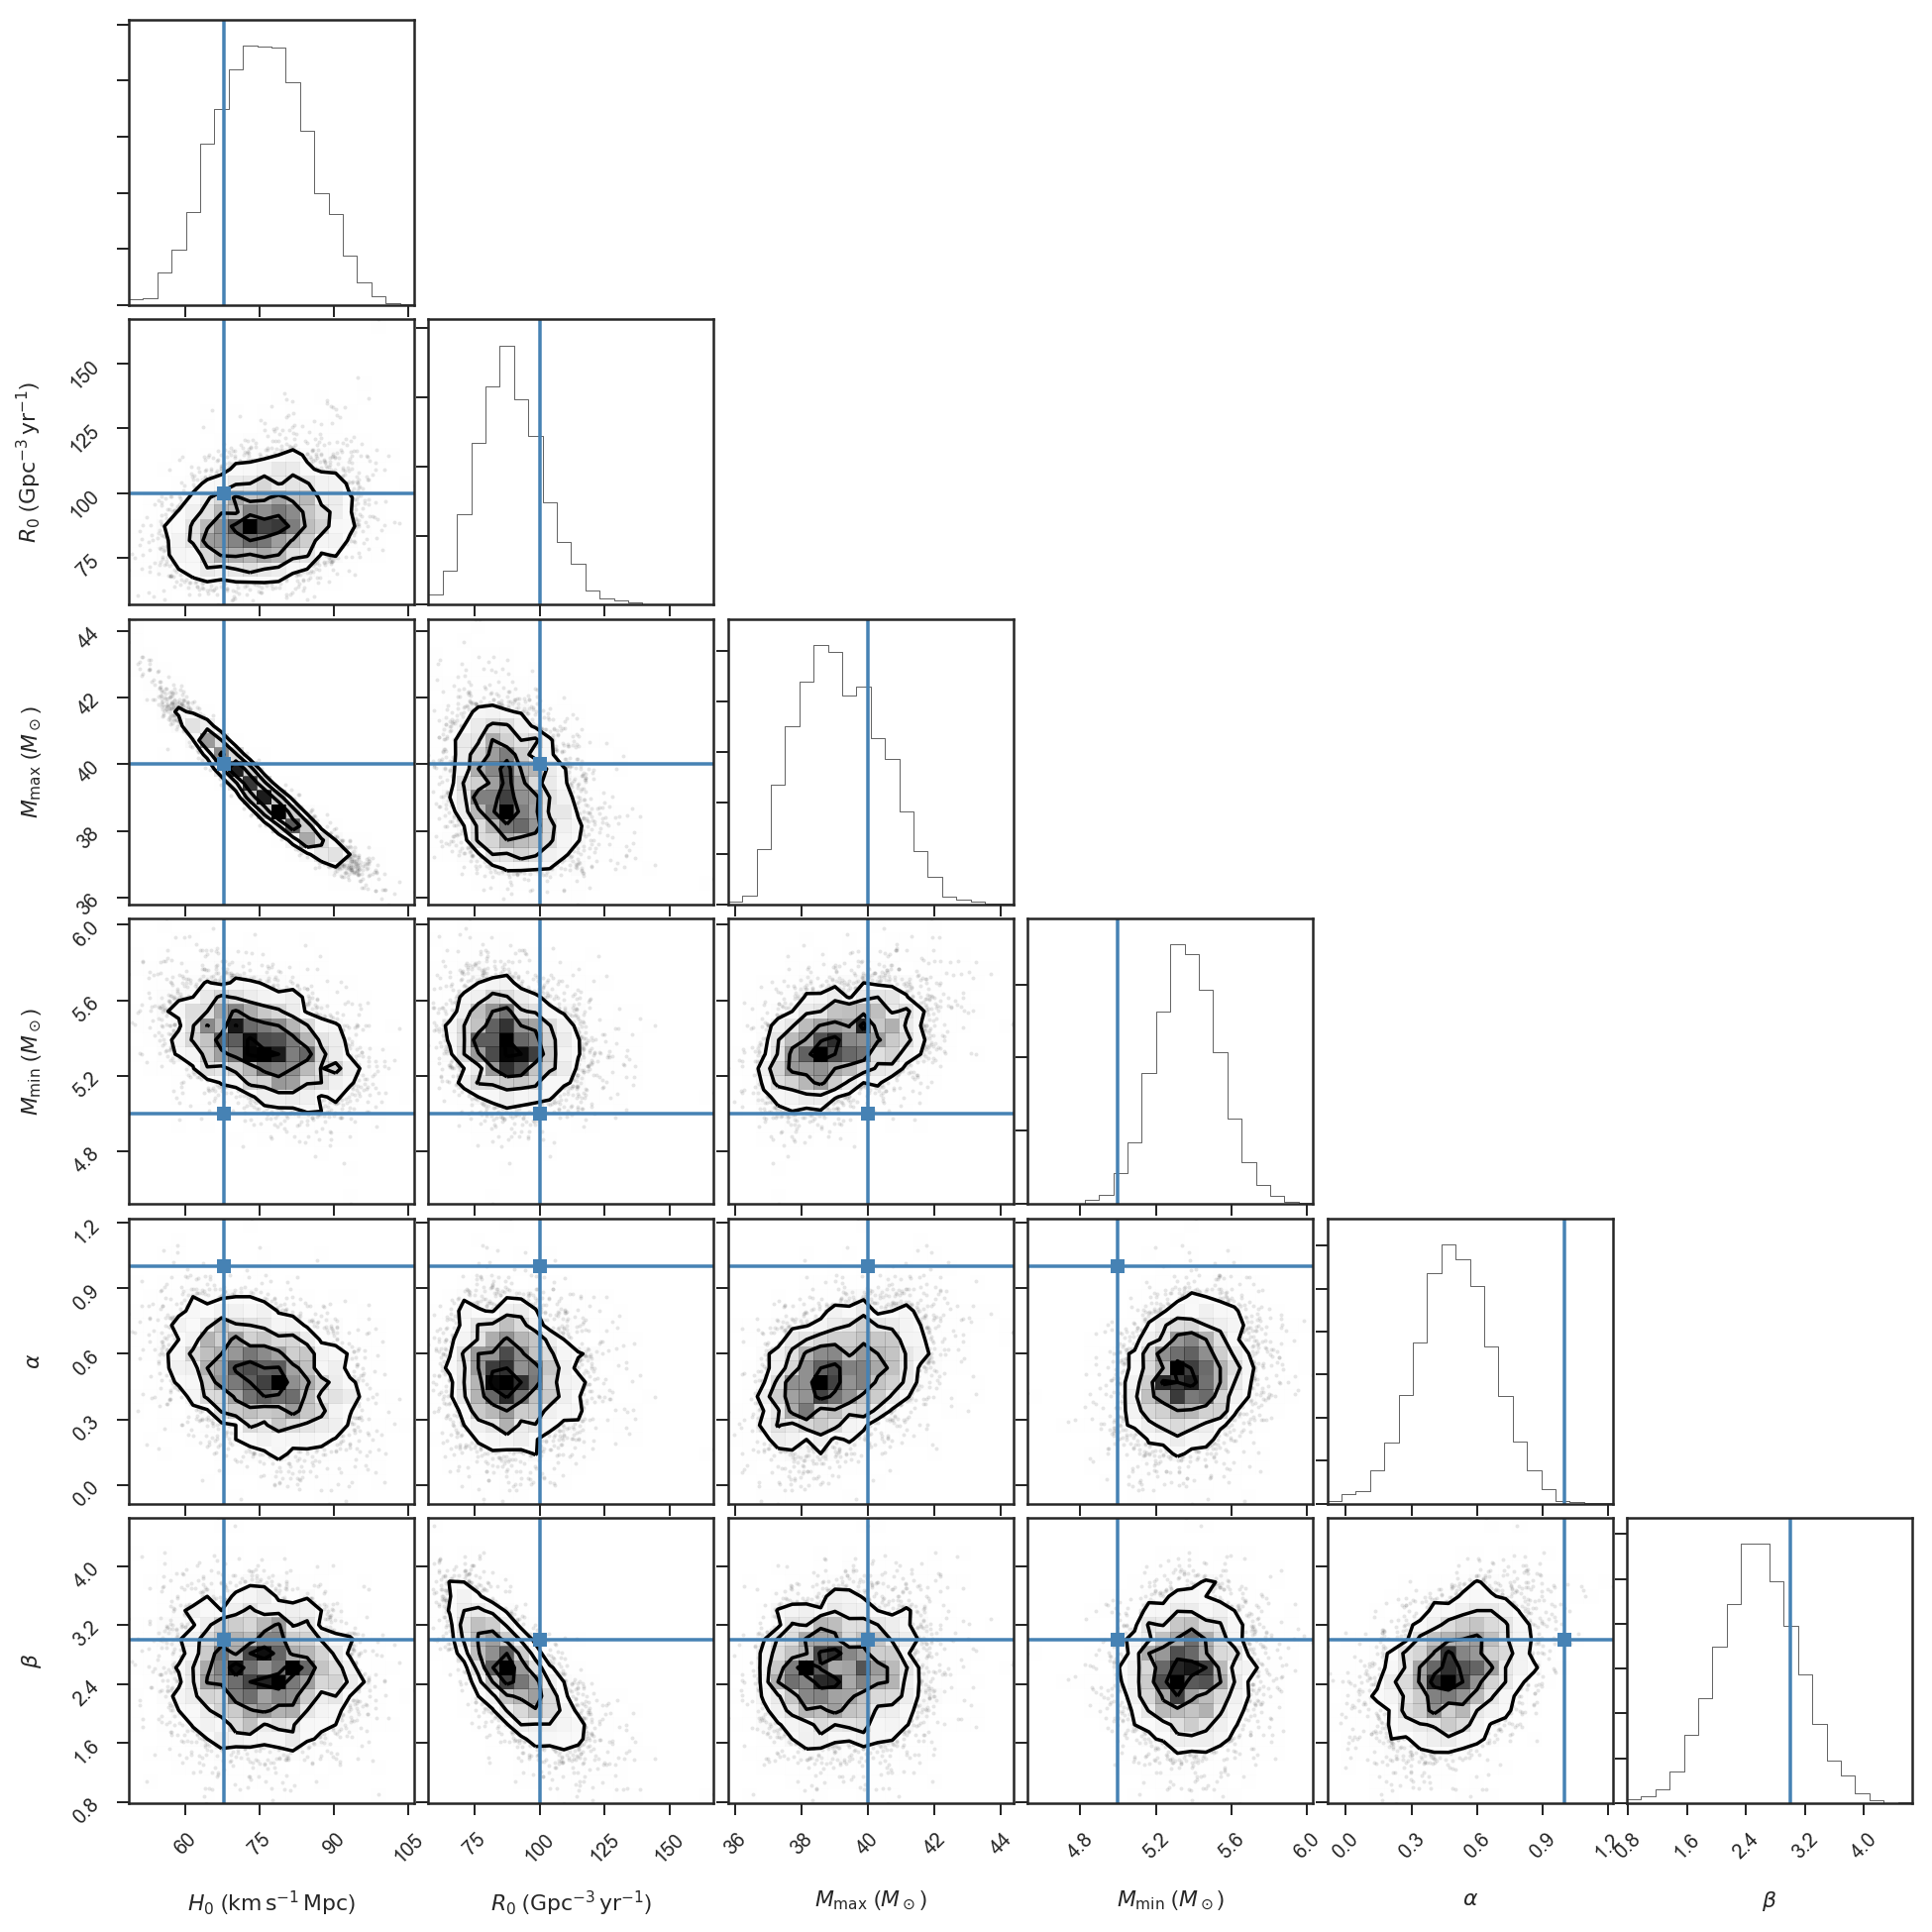

In [14]:
corner.corner(column_stack([chain_pop_1yr[nbest][n] for n in ['H0', 'R0', 'MMax', 'MMin', 'alpha', 'gamma']]), 
              labels=[r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}$)', 
                      r'$R_0$ ($\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}$)', 
                      r'$M_\mathrm{max}$ ($M_\odot$)',
                      r'$M_\mathrm{min}$ ($M_\odot$)',
                      r'$\alpha$',
                      r'$\beta$',
                      r'$\gamma$'],
              truths=[Planck15.H0.to(u.km/u.s/u.Mpc).value, 
                      100.0,
                      MMax,
                      MMin,
                      1,
                      3]);

This will efficiently find the shortest posterior interval in 1D that contains the given fraction of samples.

In [8]:
def spd_interval(samps, p):
    samps = sort(samps)
    N = samps.shape[0]
    Nint = int(round(p*N))
    Nout = N-Nint
    
    starts = samps[0:Nout]
    ends = samps[N-Nout:N]
    
    i = np.argmin(ends - starts)

    return starts[i], ends[i]

Here is the H0 plot; black line is "truth" (from ``Planck15``), blue line is posterior median, dashed is 68% CI, and dotted is 95% CI.

H0 = 75.3 + 10.6 - 8.2 km/s/Mpc (1-sigma) after one year
1-sigma interval is 9


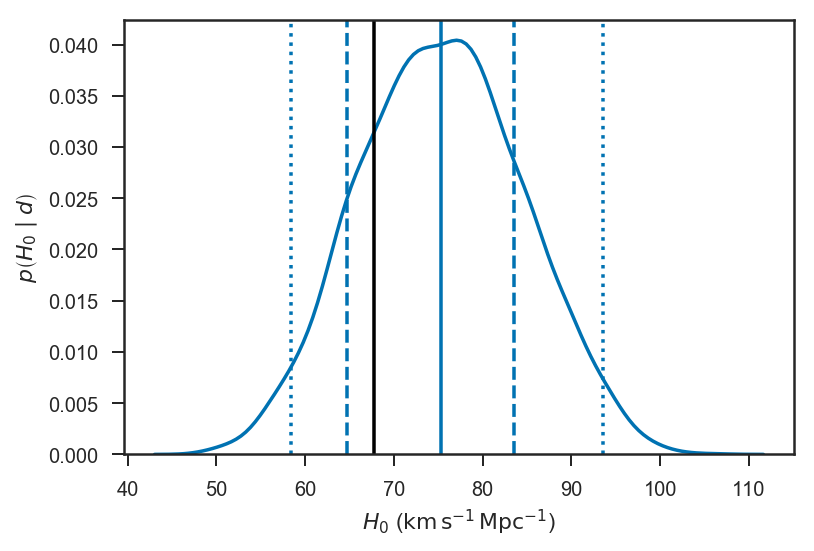

In [9]:
sns.kdeplot(chain_pop_1yr[nbest]['H0'])
xlabel(r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
ylabel(r'$p\left( H_0 \mid d \right)$')
axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value, color='k')

m = median(chain_pop_1yr[nbest]['H0'])
l, h = spd_interval(chain_pop_1yr[nbest]['H0'], 0.68)
ll, hh = spd_interval(chain_pop_1yr[nbest]['H0'], 0.95)

axvline(m)
axvline(l, ls='--')
axvline(h, ls='--')
axvline(ll, ls=':')
axvline(hh, ls=':')

dl = m-l
dh = h - m

print('H0 = {:.1f} + {:.1f} - {:.1f} km/s/Mpc (1-sigma) after one year'.format(m, dl, dh))
print('1-sigma interval is {:.0f}'.format((h-l)/2))

To check that we have converged in the required number of samples, here is a comparison of all the 1D posteriors with 400 and 800 posterior samples per event:

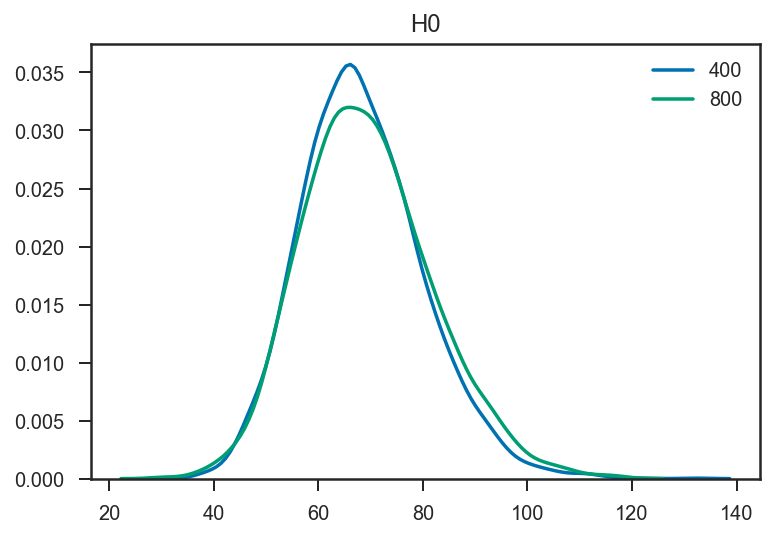

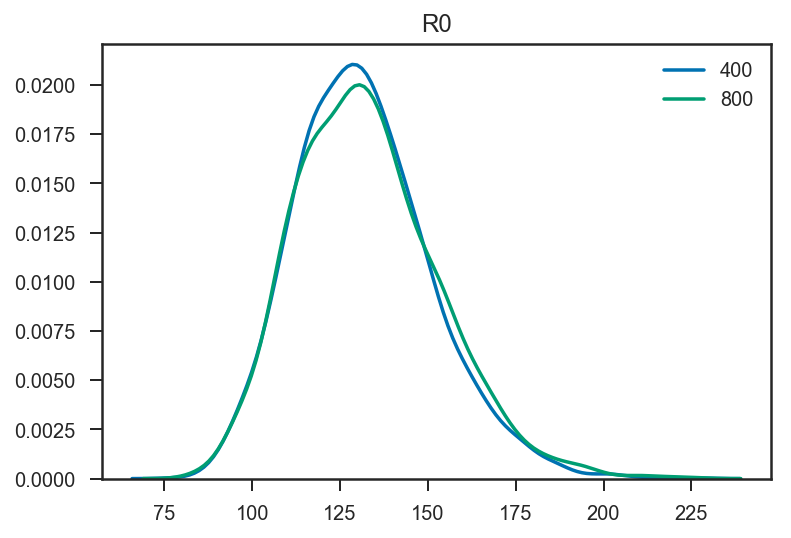

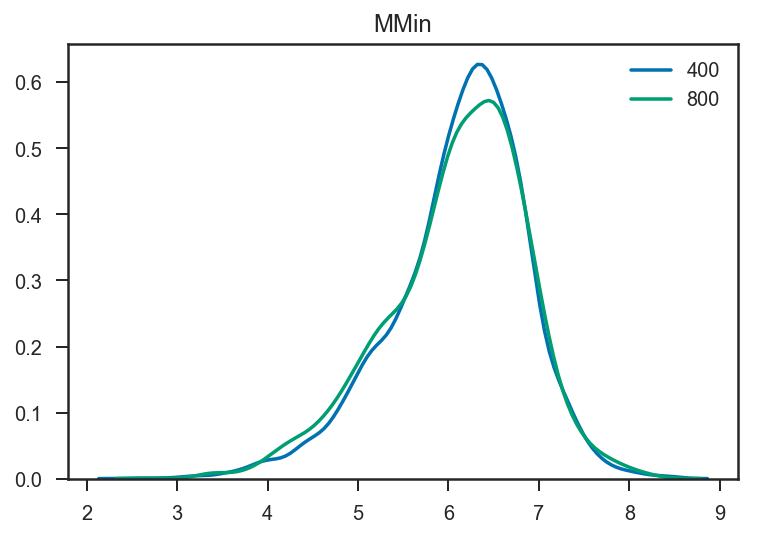

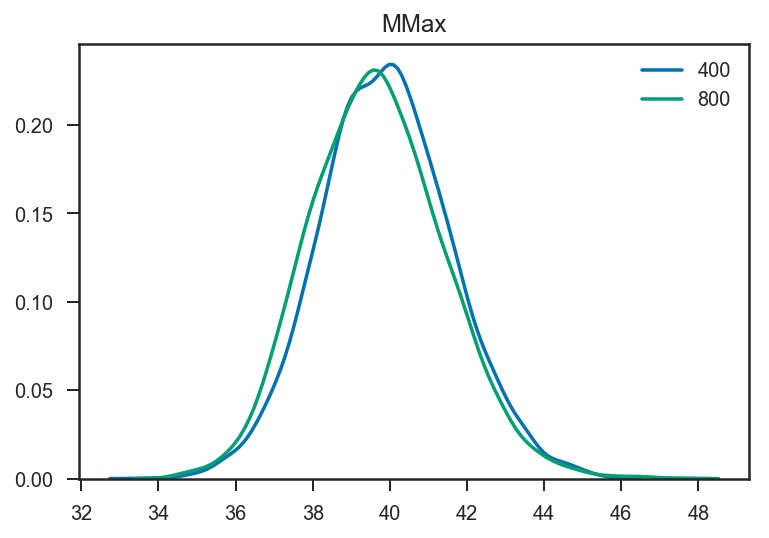

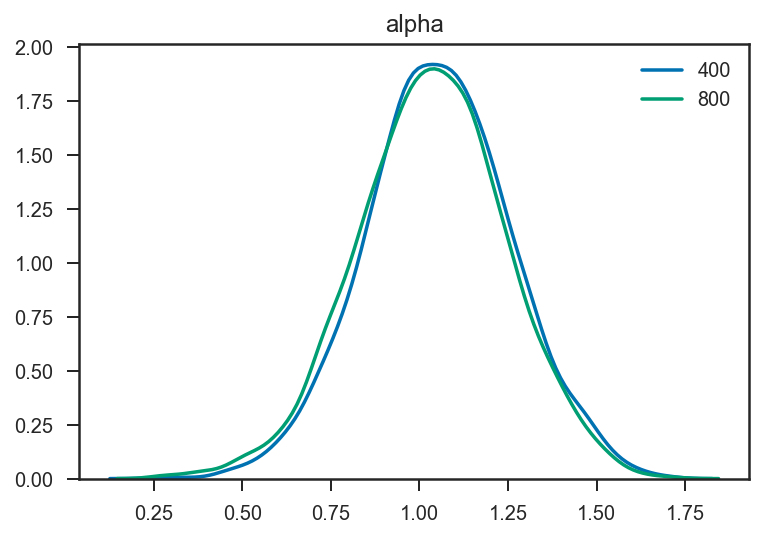

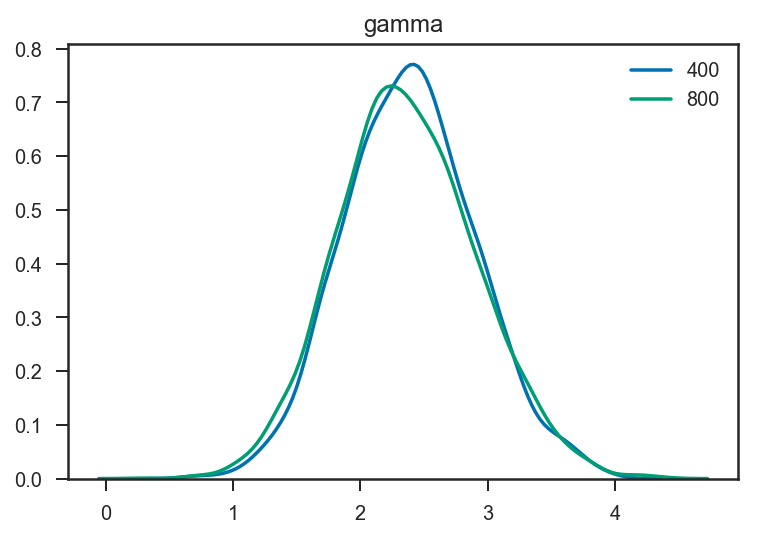

In [36]:
for n in ['H0', 'R0', 'MMin', 'MMax', 'alpha', 'gamma']:
    figure()
    title(n)
    for nn in [n2best, nbest]:
        c = chain_pop_1yr[nn][n]
        sns.kdeplot(c, label=str(nn))
    legend(loc='best')

Now the same for 5 years of data (coming soon).

In [17]:
chain_pop_5yr = {}
nbest = 800
n2best = 400
for nn in [nbest, n2best]:
    c = {}
    with h5py.File('population_5yr_{:04d}.h5'.format(nn), 'r') as inp:
        for n in ['H0', 'R0', 'MMax', 'MMin', 'alpha', 'gamma']:
            c[n] = array(inp[n])
    chain_pop_5yr[nn] = c

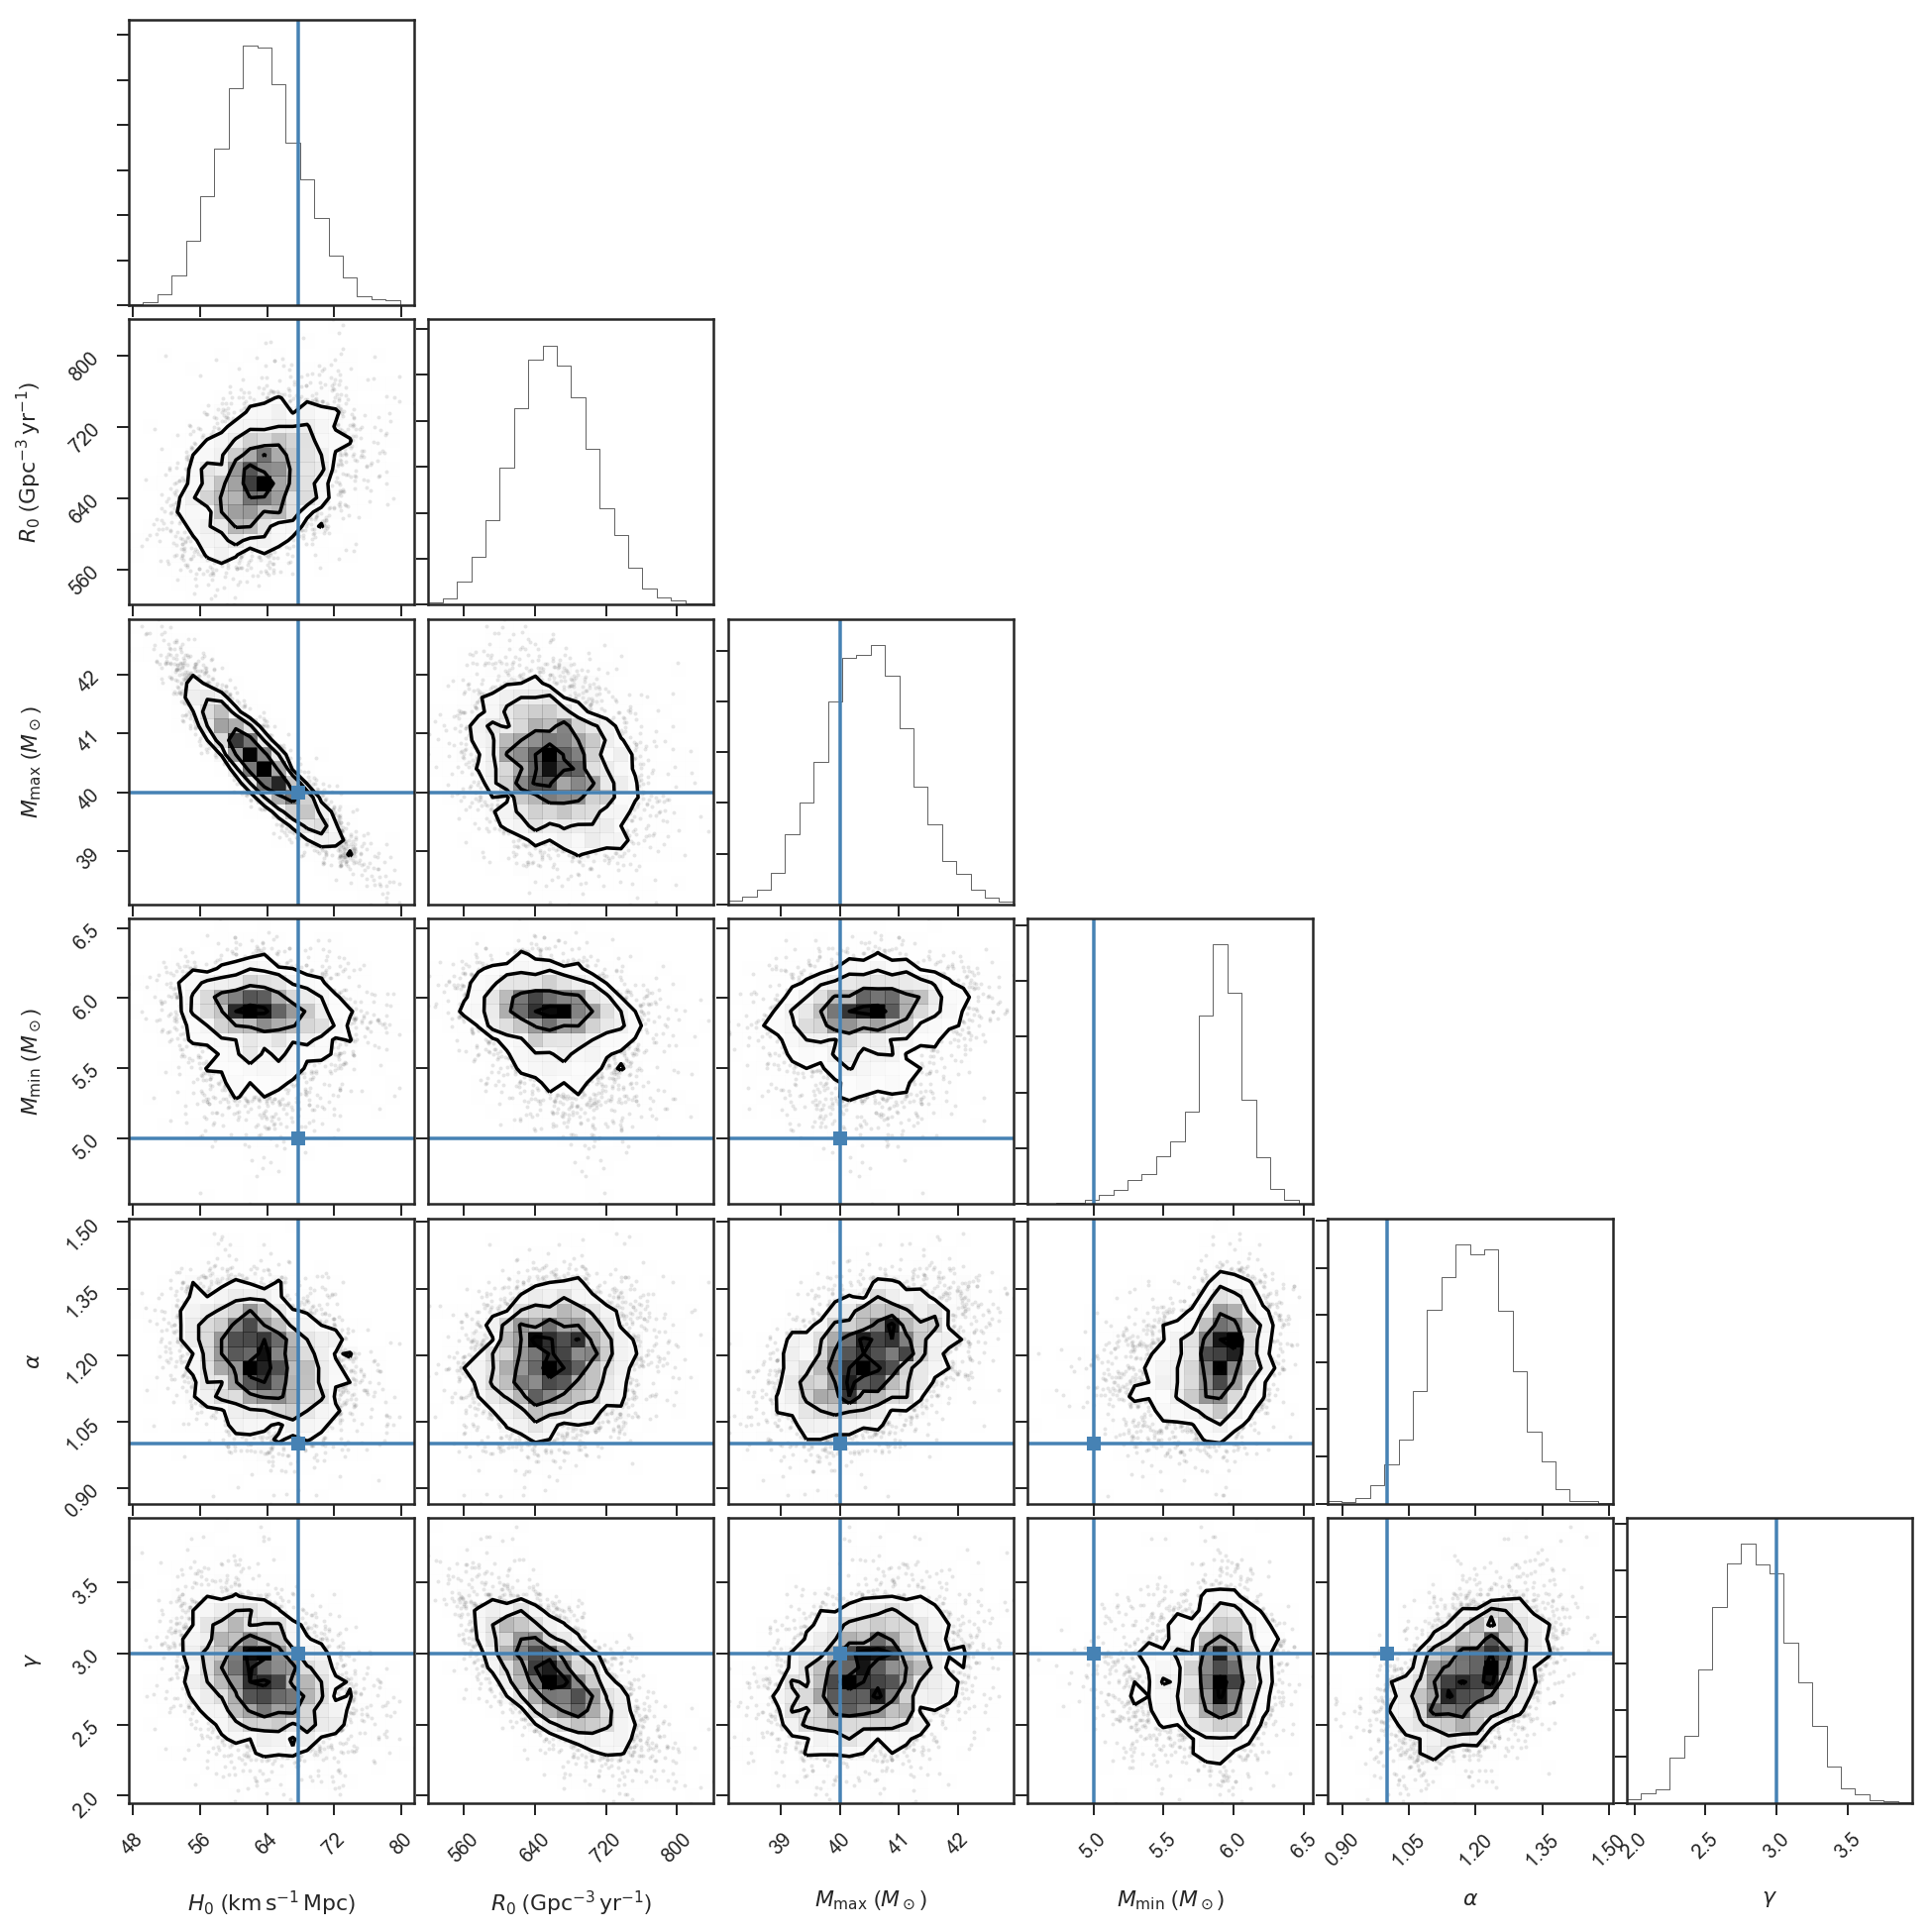

In [18]:
corner.corner(column_stack([chain_pop_5yr[nbest][n] for n in ['H0', 'R0', 'MMax', 'MMin', 'alpha', 'gamma']]), 
              labels=[r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}$)', 
                      r'$R_0$ ($\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}$)', 
                      r'$M_\mathrm{max}$ ($M_\odot$)',
                      r'$M_\mathrm{min}$ ($M_\odot$)',
                      r'$\alpha$',
                      r'$\gamma$'],
              truths=[Planck15.H0.to(u.km/u.s/u.Mpc).value, 
                      500.0,
                      MMax,
                      MMin,
                      1,
                      3]);

H0 = 63.2 + 4.8 - 4.6 km/s/Mpc (1-sigma) after one year
1-sigma interval is 5


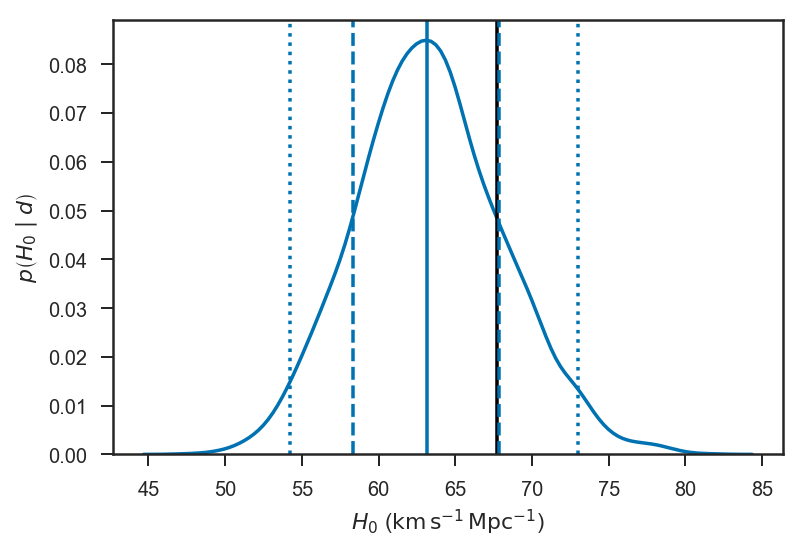

In [19]:
sns.kdeplot(chain_pop_5yr[nbest]['H0'])
xlabel(r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
ylabel(r'$p\left( H_0 \mid d \right)$')
axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value, color='k')

m = median(chain_pop_5yr[nbest]['H0'])
l, h = spd_interval(chain_pop_5yr[nbest]['H0'], 0.68)
ll, hh = spd_interval(chain_pop_5yr[nbest]['H0'], 0.95)

axvline(m)
axvline(l, ls='--')
axvline(h, ls='--')
axvline(ll, ls=':')
axvline(hh, ls=':')

dl = m-l
dh = h - m

print('H0 = {:.1f} + {:.1f} - {:.1f} km/s/Mpc (1-sigma) after one year'.format(m, dl, dh))
print('1-sigma interval is {:.0f}'.format((h-l)/2))

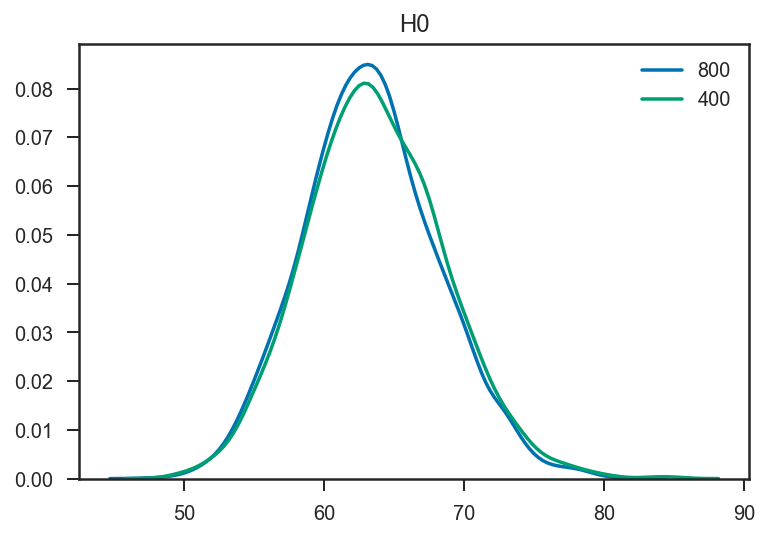

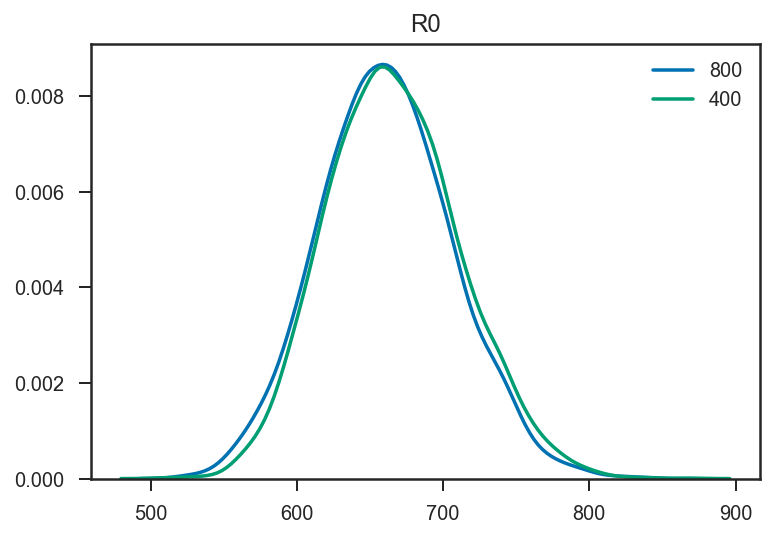

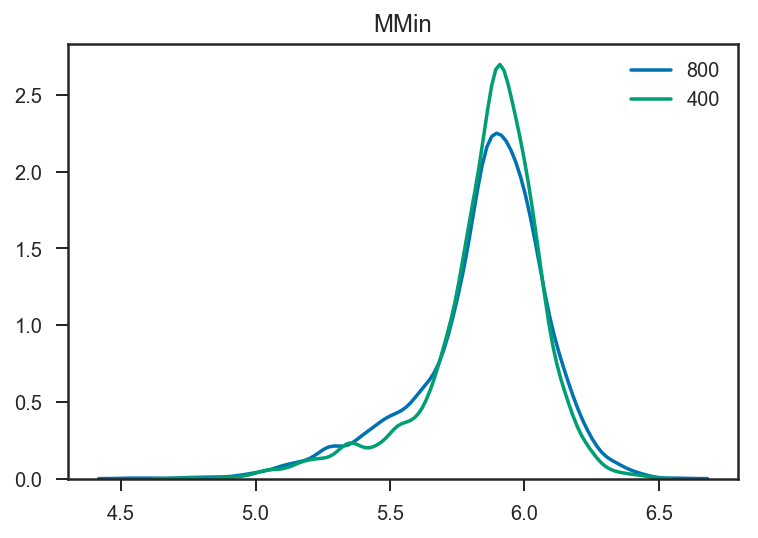

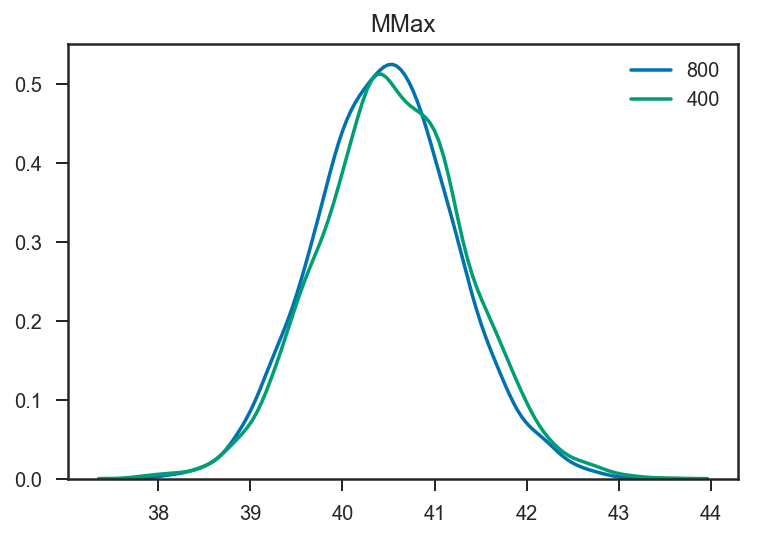

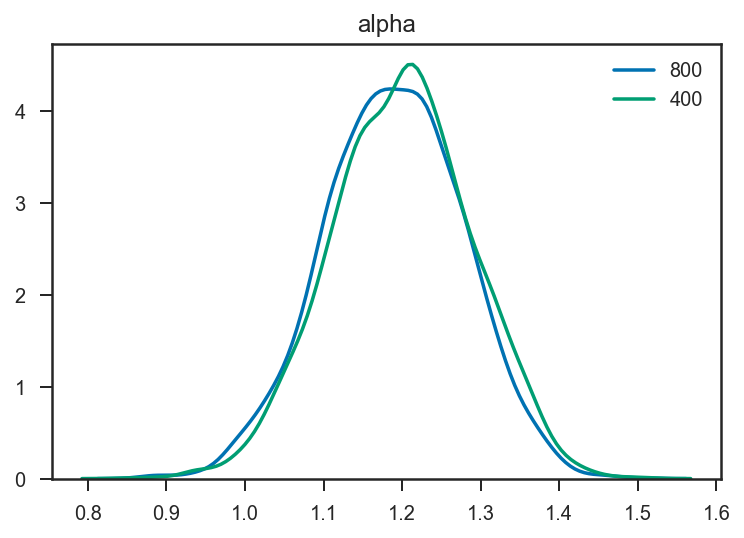

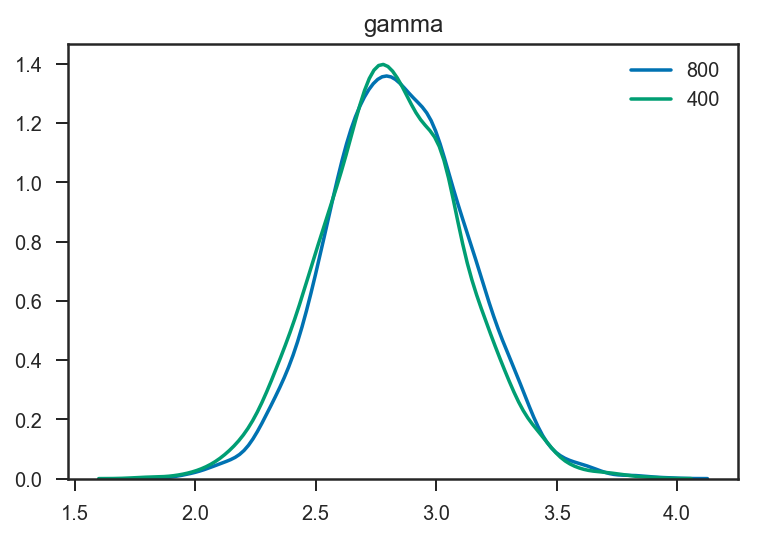

In [20]:
for n in ['H0', 'R0', 'MMin', 'MMax', 'alpha', 'gamma']:
    figure()
    title(n)
    for nn in [nbest, n2best]:
        c = chain_pop_5yr[nn][n]
        sns.kdeplot(c, label=str(nn))
    legend(loc='best')

In [8]:
N_1yr

282

In [9]:
len(m1s)

1463

In [10]:
np.max(zs)

0.9461464325828332